# TUIA NLP 2024 TRABAJO PRÁCTICO 1

**Materia:** Procesamiento del Lenguaje Natural (NLP)

**Año académico:** 2024

**Período lectivo:** 1° cuatrimestre

**Integrantes:**

- Britos Julián Francisco
- Moresco Brisa

#### Objetivo

El objetivo de este proyecto es desarrollar un programa que interactúe con el usuario para recomendar lecturas.

#### Opciones principales

El programa ofrecerá tres opciones principales:

- Recomendación Directa: El programa preguntará al usuario "¿Qué tienes ganas de leer hoy?" y, mediante la clasificación de la respuesta, propondrá una lista de tres libros acordes a las temáticas mencionadas. Además, se detallará el autor, género y una breve reseña de cada libro que se recomienda descargar.

- Elección por Autor: Si el usuario prefiere buscar por autor, el programa ofrecerá una lista de libros del autor especificado. En caso de que haya múltiples resultados, se basará en la similitud de los dos primeros resultados más relevantes, retornando dos títulos (con sus respectivas reseñas) del resultado más cercano y uno del segundo que se recomiendan para descargar. Si existen varios libros del mismo autor aleatorizar.

- Elección por Género Literario: Similar a la búsqueda por autor, si el usuario elige buscar por género, el programa ofrecerá una lista de libros del género especificado. Aplicará la misma lógica de similitud para seleccionar y presentar los resultados.


# Instalación de librerías

In [1]:
%%capture
!pip install requests
!pip install beautifulsoup4
!pip install transformers
!pip install sentence-transformers
!pip install levenshtein
!pip install fuzzywuzzy

# Obtención de datos y creación del dataset

# **(NO EJECUTAR A MENOS QUE SE PIERDA EL DATASET)**

In [ ]:
from bs4 import BeautifulSoup
import requests

url_base = "https://ww3.lectulandia.com/"
response = requests.get(url_base)
soup = BeautifulSoup(response.text, 'html.parser')

# Encuentra el enlace relativo para la página de libros (/book/)
link_element = soup.select_one('#site-navigation > ul > li:nth-child(2) > a')
url_relativa = link_element['href']

In [ ]:
from urllib.parse import urljoin

# Combina la URL base con el URL relativo para obtener un URL absoluto (https://ww3.lectulandia.com/book/)
url_absoluta = urljoin(url_base, url_relativa)

In [ ]:
# Hacemos una solicitud a la url absoluta para obtener la página a la que apunta el enlace, es decir la pagina con todos los libros
link_response = requests.get(url_absoluta)
link_soup = BeautifulSoup(link_response.text, 'html.parser')

In [ ]:
import os

# Crea la carpeta 'img' si aún no existe
if not os.path.exists('img'):
    os.makedirs('img')

Primero, obtenemos cada página y cada libro en cada página. Luego obtenemos el título, género/s, autor/es, descripción y foto de cada libro.

In [ ]:
# Establecemos el número de páginas que queremos recorrer.
n_pags = 50 # No puede ser menor a 1, ya que la página principal cuenta como la primera página.

# Creamos una lista vacía para almacenar nuestros datos.
data = []

for i in range(1, n_pags + 1):
    # Hacemos una solicitud a la url de la página i.
    link_response = requests.get(url_absoluta + f'page/{i}/')
    link_soup = BeautifulSoup(link_response.text, 'html.parser')

    # Iteramos sobre cada libro en la página.
    for libro in link_soup.select('article.card'):
        # Extrae el url de cada libro de la página i.
        url_relativa_libro = libro.select_one('h2 > a.title').get('href')
        # Combina la URL base con el URL relativo para obtener un URL absoluto (https://ww3.lectulandia.com/book/libro-de-ejemplo-1)
        url_absoluta_libro = urljoin(url_base, url_relativa_libro)
        # Imprimimos el url de cada libro.
        #print(f'url: {url_absoluta_libro}')
        # Creamos una lista con los urls de los libros y añadimos el url de cada libro a la lista.
        url_absoluta_libros = []
        url_absoluta_libros.append(url_absoluta_libro)
        # Hacemos una solicitud a la url de cada libro.
        libro_response = requests.get(url_absoluta_libro)
        libro_soup = BeautifulSoup(libro_response.text, 'html.parser')

        # Extraemos el título de cada libro.
        titulo = libro_soup.find(id='title').find('h1').text
        #print(f'Titulo: {titulo}')

        # Extraemos el autor de cada libro.
        autores_elements = libro_soup.find(id='autor').find_all('a')
        x_autores = [autor.text for autor in autores_elements]
        #print(f'Autores:\n   {x_autores}')
        # Creamos una lista con los autores de los libros y añadimos el autor de cada libro a la lista.
        autores = []
        autores.append(x_autores)

        # Extraemos el género de cada libro.
        generos_elements = libro_soup.find(id='genero').find_all('a')
        x_generos = [genero.text for genero in generos_elements]
        #print(f'Generos:\n   {x_generos}')
        # Creamos una lista con los géneros de los libros y añadimos el género de cada libro a la lista.
        generos = []
        generos.append(x_generos)

        # Extraemos la sinopsis de cada libro.
        sinopsis_element = libro_soup.find('div', class_='realign', id='sinopsis')
        if sinopsis_element is not None:
            span_element = sinopsis_element.find('span')
            if span_element is not None:
                sinopsis = span_element.text
            else:
                sinopsis = ''
        else:
            sinopsis = ''
        #print(sinopsis_element)
        #print(f'Sinopsis:\n   {sinopsis}')
        # Creamos una lista con las sinopsis de los libros y añadimos la sinopsis de cada libro a la lista.
        sinopsis_libros = []
        sinopsis_libros.append(sinopsis)

        # Descargamos la imagen de cada libro.
        img_url = libro_soup.find(id='cover').find('img').get('src')
        img_response = requests.get(img_url)
        img = img_response.content
        # Limpiamos el título para que no contenga caracteres no permitidos en un nombre de archivo.
        titulo_limpio = titulo.replace(' ', '_').replace(':', '').replace('/', '_').replace('?', '')
        # Guardamos la imagen en un archivo en la carpeta 'img'.
        with open(f'img/{titulo_limpio}.jpg', 'wb') as file:
            file.write(img)
        #print(f'Imagen guardada en img/{titulo_limpio}.jpg')

        data.append({
            'Titulo': titulo,
            'Autor': autores,
            'Genero': generos,
            'Descripcion': sinopsis
            })

    print(url_absoluta + f'page/{i}/ ✔️')

In [ ]:
import pandas as pd

libros = pd.DataFrame(data)

In [ ]:
libros.head()

In [ ]:
# Recorremos cada columna del DataFrame y, si el valor en esa columna es una lista con al menos un elemento, lo reemplazará con el primer elemento de la lista. Si el valor no es una lista o es una lista vacía, se mantendrá como está.
for column in libros.columns:
    libros[column] = libros[column].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

In [ ]:
libros.head()

Guardamos los datos en un dataset en formato Parquet, ya que Apache Parquet se basa en una representación de datos en columnas comprimidas, lo que lo hace muy eficiente para consultas analíticas que involucran grandes cantidades de datos, en comparación con otros formatos como CSV.

In [ ]:
libros.to_parquet('Libros.parquet')

# Carga de datos

In [1]:
import pandas as pd

file_path = 'Libros.parquet'
libros = pd.read_parquet(file_path)

# Análisis estadístico descriptivo

## Visualización de datos

In [2]:
libros.head()

,Titulo,Autor,Genero,Descripcion
0,Sueñan con ser como nosotras,[Jessica Goodman],"[Intriga, Juvenil, Novela]","Carismáticas, intocables, destinadas a triunfa..."
1,El descontento,[Beatriz Serrano],"[Novela, Realista]","El descontento es la historia de Marisa, una m..."
2,Palabra de reina,[Gema Bonnín],"[Histórico, Novela]",La novela sobre la vida y el poder de Catalina...
3,Irresistible,[Jose de la Rosa],"[Histórico, Novela, Romántico]","Adam Baxley, el disoluto heredero del conde de..."
4,La criatura del deseo,[Andrea Camilleri],"[Drama, Histórico, Novela]","Basándose en personajes y hechos reales, Andre..."


In [3]:
libros.isna().sum()

Titulo         0
Autor          0
Genero         0
Descripcion    0
dtype: int64

In [4]:
libros.describe()

,Titulo,Autor,Genero,Descripcion
count,1200,1200,1200,1200
unique,1159,906,1200,1152
top,Huellas enemigas,[Varios Autores],"[Intriga, Juvenil, Novela]","Nacido en la Misia oriental en 117, Elio Arist..."
freq,2,12,1,4


Aquí vemos cómo él describe nos muestra que existen  906 valores únicos para autores y  1200 valores únicos para géneros, sin embargo, los libros al poder tener más de un autor o genero la solución que buscamos a la hora de crear el dataset fue ponerlos en listas y este formato es que puede causar que el 'describe' no esté realmente mostrando los valores únicos, ya que por ejemplo si tenemos ['Batalla', 'Novela'] y ['Novela'] el 'describe' tomará que hay dos géneros totales y dos géneros únicos cuando realmente hay 3 géneros totales, pero solamente 2 únicos para solucionar esto hacemos:

In [5]:
generos_unicos = libros['Genero'].explode().unique()
autores_unicos = libros['Autor'].explode().unique()
generos_unicos.size, autores_unicos.size

(70, 1018)

Ahora sí podemos ver cuantos géneros y autores existen realmente, siendo estos 70 y 1018 correspondientemente.

## Gráficos

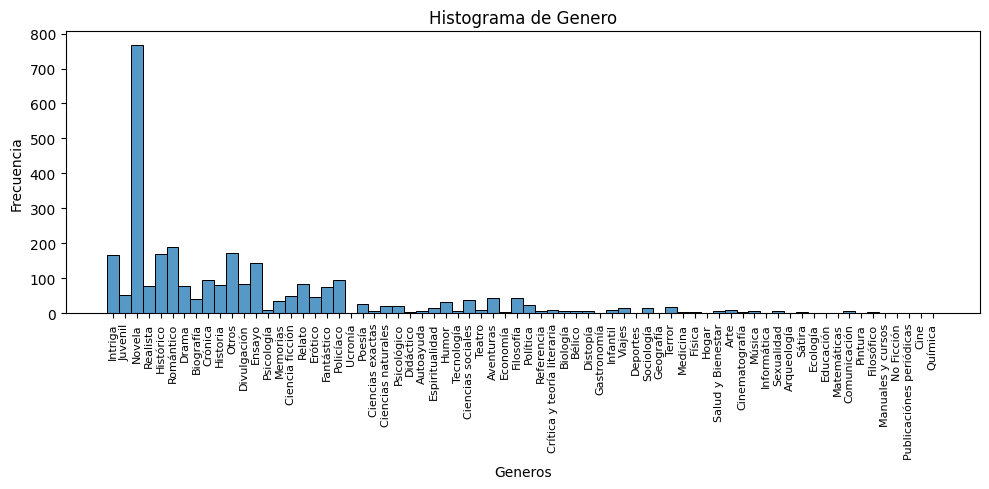

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(figsize=(10, 5))

# Histograma       creamos un dataframe con los generos de la sublista de generos de cada libro
sns.histplot(pd.DataFrame([genero for sublist in libros['Genero'] for genero in sublist], columns=['Genero'])['Genero'])
axs.set_title('Histograma de Genero')
axs.set_xlabel('Generos')
axs.set_ylabel('Frecuencia')

plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

# Recomendación directa

In [7]:
user_input = input("¿Qué tienes ganas de leer hoy?\n") #Algo de psicologia

In [8]:
import torch
from transformers import BertTokenizer, BertModel
from torch.nn.functional import cosine_similarity

# Cargar el tokenizador y el modelo BERT multilingüe
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

In [9]:
# Definir la función para obtener los embeddings de un texto
def get_embedding(text):
    # Tokenizar el texto, convirtiéndolo en tensores y asegurando la longitud máxima y el padding
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    # Desactivar el cálculo del gradiente ya que estamos en modo de inferencia
    with torch.no_grad():
        # Pasar los tokens a través del modelo BERT para obtener los embeddings
        outputs = model(**tokens)
    # Promediar los embeddings de los tokens para obtener un solo vector de representación
    return outputs.last_hidden_state.mean(dim=1)

In [10]:
# Obtener los embeddings de las descripciones de los libros
libros['Embedding'] = libros['Descripcion'].apply(get_embedding)

In [11]:
# Definir la función para recomendar libros basados en la entrada del usuario
def recomendar_libros(user_input):
    # Obtener el embedding de la entrada del usuario
    user_embedding = get_embedding(user_input)
    # Calcular la similitud del coseno entre el embedding del usuario y los embeddings de los libros
    libros['Similitud'] = libros['Embedding'].apply(lambda x: cosine_similarity(user_embedding, x).item())
    # Ordenar los libros por la similitud en orden descendente
    libros_ordenados = libros.sort_values(by='Similitud', ascending=False)
    # Retornar los primeros 'top_n' libros más similares
    return libros_ordenados.head(3)

In [12]:
# Obtener las recomendaciones
recomendaciones = recomendar_libros(user_input)

In [13]:
# Mostrar las recomendaciones
for index, row in recomendaciones.iterrows():
    print(f"Título: {row['Titulo']}")
    print(f"Autor: {row['Autor']}")
    print(f"Género: {', '.join(row['Genero'])}")
    print(f"Descripción: {row['Descripcion']}\n")
    print(f"Similitud: {row['Similitud']:.4f}\n")

Título: Problemas epistemológicos de la Psicología
Autor: ['Fernando González Rey']
Género: Psicología, Referencia
Descripción: La presente monografía aborda los fundamentos y métodos que sustentan la teoría del conocimiento en una de las más importantes ramas de la ciencia: la psicología. El intentar adentrarse en un terreno tan polémico, es un desafío enorme para cualquier investigador, y el doctor González Rey logra vencer con acierto y cientificidad ese reto.A través de cuatro capítulos el autor trata cuestiones tan vitales como la relación entre lo técnico y lo empírico, el vínculo entre lo técnico y lo metodológico en la psicología, la construcción del conocimiento en la psicología y la relación personalidad-sujeto-sociedad en las ciencias sociales, entre otros tópicos.

Similitud: 0.5644

Título: El lenguaje olvidado
Autor: ['Erich Fromm']
Género: Ensayo, Psicología
Descripción: Introducción a la comprensión de los sueños, mitos y cuentos de hadasÚnico lenguaje común a toda la h

# Recomendación por autor

In [18]:
user_input_a = input("¿Qué autor tienes ganas de leer hoy?\n") #'Stephen King'

Usamos la Distancia de Levenshtein

In [19]:
# Lista de géneros únicos para la coincidencia difusa
autores = set([g for sublist in libros['Autor'] for g in sublist])

In [20]:
import Levenshtein

t = user_input_a

# Inicializar variables para almacenar el autor con la menor distancia y la distancia mínima
min_distance_a = float('inf')
closest_author = None

for autor in autores:
    s = autor
    distance = Levenshtein.distance(s, t)
    if distance < min_distance_a:
            min_distance_a = distance
            closest_author = autor

# Filtrar el DataFrame para mostrar solo los libros del autor más cercano
filtered_df = libros[libros['Autor'].apply(lambda x: closest_author in x)]

# Mostrar el autor más cercano y el DataFrame filtrado
print(f"Autor más cercano: {closest_author}")

Autor más cercano: Stephen King


In [21]:
filtered_df

,Titulo,Autor,Genero,Descripcion,Embedding,Similitud
350,Holly,[Stephen King],"[Novela, Policíaco]",Cuando Penny Dahl contacta con Finders Keepers...,"[[tensor(-0.4467), tensor(-0.5030), tensor(0.1...",0.439348


# Recomendación por generos

In [22]:
user_input_g = input("¿Qué genero tienes ganas de leer hoy?\n")#'Accion'

## Mediante la distancia de Levenshtein

In [23]:
# Lista de géneros únicos para la coincidencia difusa
generos = set([g for sublist in libros['Genero'] for g in sublist])

In [24]:
import Levenshtein

t = user_input_g

# Inicializar variables para almacenar el autor con la menor distancia y la distancia mínima
min_distance_g = float('inf')
closest_generes = None

for genero in generos:
    s = genero
    distance_g = Levenshtein.distance(s, t)
    if distance_g < min_distance_g:
            min_distance_g = distance_g
            closest_generes = genero

# Filtrar el DataFrame para mostrar solo los libros del autor más cercano
filtered_df_generos = libros[libros['Genero'].apply(lambda x: closest_generes in x)]

# Mostrar el autor más cercano y el DataFrame filtrado
print(f"Genero más cercano: {closest_generes}")

Genero más cercano: Terror


In [25]:
filtered_df_generos

,Titulo,Autor,Genero,Descripcion,Embedding,Similitud
255,La chica más fría de Coldtown,[Holly Black],"[Fantástico, Novela, Terror]",Tana vive en un mundo en el que existen ciudad...,"[[tensor(-0.1865), tensor(-0.5791), tensor(-0....",0.398286
264,La chica más fría de Coldtown,[Holly Black],"[Fantástico, Novela, Terror]",Tana vive en un mundo en el que existen ciudad...,"[[tensor(-0.1865), tensor(-0.5791), tensor(-0....",0.398286
338,La sombra en llamas,[Jonathan Stroud],"[Fantástico, Novela, Terror]",Lucy va por libre y está trabajando para agenc...,"[[tensor(0.0822), tensor(-0.2983), tensor(-0.0...",0.440376
373,El cuarto secreto,[Tono Galiana],"[Novela, Terror]","No podía ser de otra manera, tanto abuso, tant...","[[tensor(-0.1068), tensor(-0.4651), tensor(-0....",0.376536
417,"Zothique, el último continente",[Clark Ashton Smith],"[Fantástico, Otros, Relato, Terror]",Junto con sus colegas y amigos epistolares H.P...,"[[tensor(-0.0272), tensor(-0.3768), tensor(0.4...",0.385985
579,Eco,[Thomas Olde Heuvelt],"[Novela, Terror]",Hay quien dice que no hay nada peor que perder...,"[[tensor(-0.2526), tensor(-0.5117), tensor(0.2...",0.394510
667,Mystic Topaz,[Pilar Pedraza],"[Fantástico, Relato, Terror]",Cuando abrimos un libro de Pilar Pedraza a men...,"[[tensor(-0.0077), tensor(-0.1884), tensor(0.0...",0.405932
686,Corazón caníbal,[Miguel Cané],"[Intriga, Novela, Terror]","Claudia Castañeda, joven mexicana en Estados U...","[[tensor(-0.0798), tensor(-0.3345), tensor(0.0...",0.401899
778,Océanos de tiempo,[Jerónimo Tristante],"[Novela, Terror]","Madrid, 1892. El prestigioso psiquiatra August...","[[tensor(-0.1149), tensor(-0.5013), tensor(-0....",0.432018
808,Los recuerdos del hombre del saco,"[Goretti Irisarri, Jose Gil Romero]","[Relato, Terror]",Un periodista está realizando una serie de ent...,"[[tensor(0.1288), tensor(-0.5267), tensor(-0.0...",0.423366


## Mediante Embedding (Bert)

In [26]:
import torch
from transformers import BertTokenizer, BertModel
from torch.nn.functional import cosine_similarity
import pandas as pd

# Lista de géneros únicos para la coincidencia difusa
generos_unicos = set([g for sublist in libros['Genero'] for g in sublist])

# Get the number of unique genres
num_unique_genres = len(generos_unicos)

# Print the number of unique genres
print(f"Number of unique genres: {num_unique_genres}")

Number of unique genres: 70


In [27]:
import fuzzywuzzy.process as process
import fuzzywuzzy.fuzz as fuzz
# Definir la función para calcular la similitud del coseno entre dos textos
def calcular_similitud(texto1, texto2):
    embedding_texto1 = get_embedding(texto1)
    embedding_texto2 = get_embedding(texto2)
    similitud = cosine_similarity(embedding_texto1, embedding_texto2).item()
    return similitud

# Definir la función para recomendar libros por género
def recomendar_por_genero(libros, genero, top_n=3):
    # Convertir el género a minúsculas y encontrar la coincidencia difusa más cercana
    genero = genero.lower()
    mejor_genero = process.extractOne(genero, generos_unicos, scorer=fuzz.partial_ratio)
    if mejor_genero[1] < 80:  # Umbral de similitud del 80%
        print(f"No se encontró un género similar a '{genero}'.")
        return pd.DataFrame()  # Retornar un DataFrame vacío

    # Calcular la similitud del coseno entre la descripción del género y la entrada del usuario
    similitudes = []
    for index, row in libros.iterrows():
        descripcion = ' '.join(row['Genero'])  # Unimos los géneros en una cadena para obtener la descripción del género
        similitud = calcular_similitud(descripcion, mejor_genero[0])
        similitudes.append((index, similitud))

    # Ordenar los libros por similitud (en este caso no calculamos similitud, solo mostramos)
    libros_ordenados = pd.DataFrame(similitudes, columns=['Index', 'Similitud']).sort_values(by='Similitud', ascending=False)
    libros_ordenados = libros_ordenados.head(top_n)
    libros_filtrados = libros.loc[libros_ordenados['Index']]

    return libros_filtrados

In [28]:
# Obtener las recomendaciones de libros basadas en el género especificado
recomendaciones = recomendar_por_genero(libros, user_input_g)

# Verificar si se encontraron recomendaciones
if not recomendaciones.empty:
    # Mostrar las recomendaciones con sus detalles
    for index, row in recomendaciones.iterrows():
        print(f"Título: {row['Titulo']}")  # Imprimir el título del libro
        print(f"Autor: {row['Autor']}")  # Imprimir el autor del libro
        print(f"Género: {', '.join(row['Genero'])}")  # Imprimir el género del libro
        print(f"Descripción: {row['Descripcion']}\n")  # Imprimir la descripción del libro
else:
    print("No se encontraron recomendaciones.")

Título: Las aventuras de Geppetto
Autor: ['Goretti Irisarri' 'Jose Gil Romero']
Género: Relato, Terror
Descripción: El señor Geppetto lleva una vida solitaria; bebe de más y trabaja limpiando los burros de la isla de los uguetes, recogiendo las ropas de los niños desaparecidos. Una mañana, sin embargo, el señor Geppetto se descubre en el brazo algo que cambiará su existencia.

Título: Los recuerdos del hombre del saco
Autor: ['Goretti Irisarri' 'Jose Gil Romero']
Género: Relato, Terror
Descripción: Un periodista está realizando una serie de entrevistas a un asesino que lleva preso cinco años y que es conocido como el hombre del saco.Tras la primera entrevista, el periodista comienza a recordar unos misteriosos acontecimientos para los que no encuentra explicación.

Título: Tres grandes robles junto a los avellanos
Autor: ['Goretti Irisarri' 'Jose Gil Romero']
Género: Relato, Terror
Descripción: Mediados del siglo XIX. Un bosque en la Rusia prerevolucionaria. Un hombre. Una mujer. Un ra